In [1]:
import scanpy as sc
import phate
import scprep
import gspa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# data and metadata from https://www.nature.com/articles/s41587-019-0336-3
data = pd.read_pickle('data/eb_data.pkl.gz')
metadata = pd.read_pickle('data/eb_metadata.pkl.gz')
adata = sc.AnnData(data)
adata.obs = metadata

## Re-embed with localized genes

In [3]:
results = np.load('../results/eb_gene_embedding.npz', allow_pickle=True)

In [20]:
threshold = np.percentile(results['localization_score'], q=75)
localized_genes = results['genes'][results['localization_score'] > threshold]
loc_phate_op = phate.PHATE(random_state=42, verbose=False)
data_loc_phate = loc_phate_op.fit_transform(adata[:, localized_genes].to_df())

<Axes: title={'center': 'Embedding top loc genes'}>

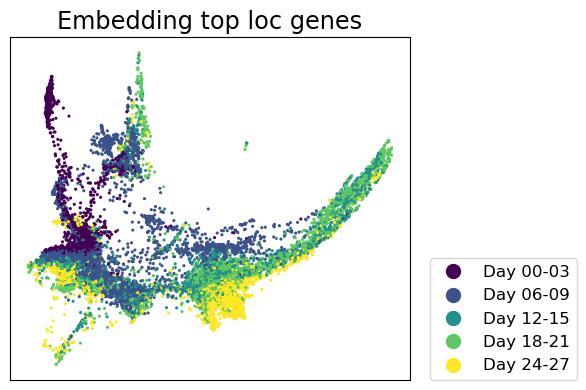

In [21]:
scprep.plot.scatter2d(data_loc_phate, c=adata.obs['sample_labels'], legend_loc=(1.05, 0), figsize=(6,4), ticks=None, dpi=300,
                      title='Embedding top loc genes', filename='figures/eb_loc_reembedding.png', cmap='viridis')

In [22]:
threshold = np.percentile(results['localization_score'], q=25)
nonlocalized_genes = results['genes'][results['localization_score'] < threshold]
nonloc_phate_op = phate.PHATE(random_state=42, verbose=False)
data_nonloc_phate = nonloc_phate_op.fit_transform(adata[:, nonlocalized_genes].to_df())

In [23]:
data_nonloc_phate[:, 0] = data_nonloc_phate[:, 0]*-1 # ensures timepoints increase from left to right

<Axes: title={'center': 'Embedding bottom loc genes'}>

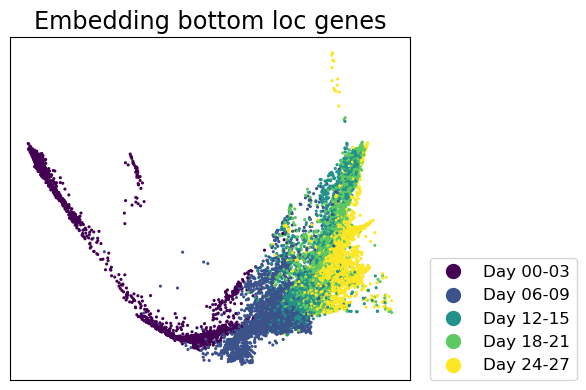

In [24]:
scprep.plot.scatter2d(data_nonloc_phate, c=adata.obs['sample_labels'], legend_loc=(1.05, 0), figsize=(6,4), ticks=None, dpi=300,
                      title='Embedding bottom loc genes', filename='figures/eb_nonloc_reembedding.png', cmap='viridis')

## Correlation between geodesic distances

In [ ]:
phate_op = phate.PHATE(random_state=42, verbose=False)
data_phate = phate_op.fit_transform(adata.to_df())

In [ ]:
true_geodesic_dist = phate_op.graph.shortest_path(distance='affinity')
true_geodesic_dist = squareform(true_geodesic_dist, checks=False) # is symmetric within tolerance

In [ ]:
corrs= []
for _ in range(2):
    idx = np.random.choice(true_geodesic_dist.shape[0], size=100000, replace=False)
    for j,p in enumerate([loc_phate_op, nonloc_phate_op]):
        geodesic_dist = p.graph.shortest_path(distance='affinity')
        geodesic_dist = squareform(geodesic_dist, checks=False) # is symmetric within tolerance
        corr = spearmanr(true_geodesic_dist[idx], geodesic_dist[idx])
        corrs.append(corr)
        print (j, corr)

In [ ]:
df = pd.DataFrame([['Localized', 'Non-localized', 'Localized', 'Non-localized'], 
             [c.statistic for c in corrs]]).T

In [25]:
df

,0,1
0,Localized,0.745697
1,Non-localized,0.678022
2,Localized,0.744565
3,Non-localized,0.680235


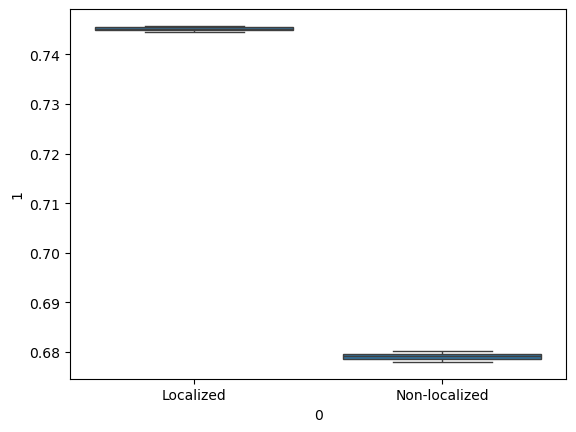

In [24]:
fig, ax = plt.subplots()
sns.boxplot(data=df, x=0, y=1, ax=ax)
fig.savefig('figures/eb_geodesic_spearmanr.png', dpi=200)

In [105]:
results = np.load('results/eb_results/eb_gene_embedding.npz', allow_pickle=True)
genes = np.array([x.split(' (')[0] for x in results['genes']])

In [107]:
gene_phate_op = phate.PHATE(random_state=42, t=40, use_pygsp=True)
gene_phate = gene_phate_op.fit_transform(results['signal_embedding'][~pd.Series(genes).isin(['MT-ATP6', 'MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-CYB', 'MT-ND1',
       'MT-ND2', 'MT-ND3', 'MT-ND4', 'MT-ND5'])])
genes = genes[~pd.Series(genes).isin(['MT-ATP6', 'MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-CYB', 'MT-ND1',
       'MT-ND2', 'MT-ND3', 'MT-ND4', 'MT-ND5'])]

Calculating PHATE...
  Running PHATE on 17835 observations and 128 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.24 seconds.
    Calculating KNN search...
    Calculated KNN search in 60.05 seconds.
    Calculating affinities...
    Calculated affinities in 30.79 seconds.
  Calculated graph and diffusion operator in 91.77 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 3.39 seconds.
    Calculating KMeans...
    Calculated KMeans in 5.33 seconds.
  Calculated landmark operator in 10.37 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.72 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.73 seconds.
Calculated PHATE in 108.59 seconds.


In [69]:
evs = gene_phate_op.graph.U
evs_sub = evs[:, :50]
evs_sub = pd.DataFrame(MinMaxScaler().fit_transform(evs_sub), index=genes)

2024-05-23 16:30:33,530:[WARNING](pygsp.graphs.graph._check_fourier_properties): The Fourier basis G.U is not available, we need to compute the Fourier basis. Explicitly call G.compute_fourier_basis() once beforehand to suppress the warning.
2024-05-23 16:30:33,531:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (17845 x 17845) may take some time.


In [97]:
scprep.plot.scatter2d(gene_phate, c=genes=='PECAM1')

ValueError: Expected c of length 17845 or 1. Got 17835

In [116]:
evs_sub.index= np.array([x.split(' (')[0] for x in results['genes']])

In [121]:
evs_sub_no_mt = evs_sub.loc[~evs_sub.index.isin(['MT-ATP6', 'MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-CYB', 'MT-ND1',
       'MT-ND2', 'MT-ND3', 'MT-ND4', 'MT-ND5'])]

<Axes: >

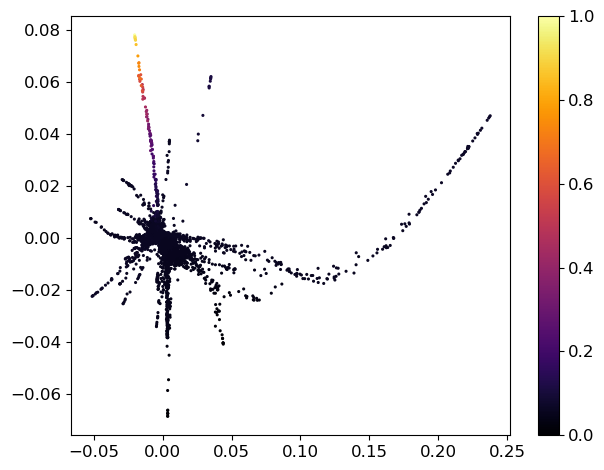

In [134]:
scprep.plot.scatter2d(gene_phate, c=1-evs_sub_no_mt[4], )

In [135]:
hemangioblast_lineage = [['NANOG', 'POU5F1'], ['EOMES', 'MIXL1', 'CER1', 'SATB1', 'T'], ['T'],
                     ['TAL1', 'CD34', 'PECAM1']]

In [198]:
df = pd.DataFrame((1-evs_sub.loc[[y for x in hemangioblast_lineage for y in x]][4]).sort_values())

In [199]:
sns.scatterplot(dat

,4
NANOG,0.059869
POU5F1,0.060040
SATB1,0.060227
T,0.063060
T,0.063060
EOMES,0.063427
MIXL1,0.064142
CER1,0.064248
PECAM1,0.551592
TAL1,0.580715


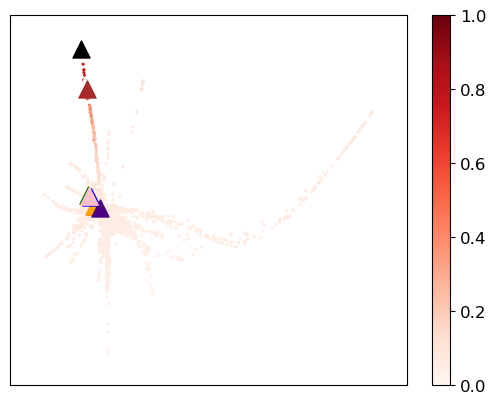

In [194]:
fig, ax = plt.subplots()
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet', 'pink', 'white', 'black', 'brown']
scprep.plot.scatter2d(gene_phate, c=1-evs_sub_no_mt[4], ax=ax, cmap='Reds')
for i,gene in enumerate([y for x in hemangioblast_lineage for y in x]):
    scprep.plot.scatter2d(gene_phate, mask=pd.Series(genes).isin([gene]), marker='^',
                          ax=ax, s=150, ticks=None, label=gene, c=colors[i])

fig.savefig('results/eb_results/eb_selected_genes.png', dpi=300)

In [195]:
[y for x in hemangioblast_lineage for y in x]

['NANOG',
 'POU5F1',
 'EOMES',
 'MIXL1',
 'CER1',
 'SATB1',
 'T',
 'T',
 'TAL1',
 'CD34',
 'PECAM1']

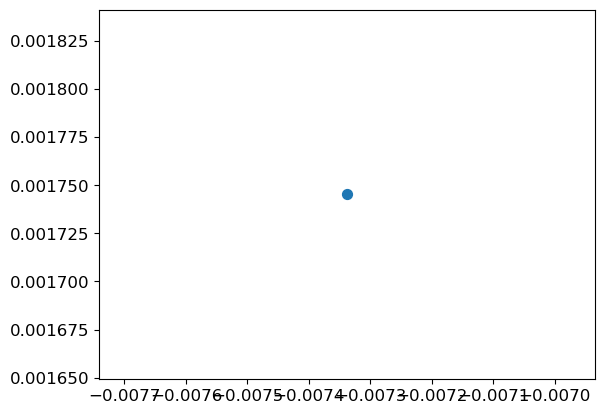

In [181]:
fig, ax = plt.subplots()
scprep.plot.scatter2d(gene_phate, mask=genes == gene, ax=ax, s=50)
for i,gene in enumerate(['NANOG']):
    ax.annotate(gene, (gene_phate[i, 0], gene_phate[i, 1]))

In [ ]:
fig, ax = plt.subplots()
scprep.plot.scatter2d(gene_phate, c=1-evs_sub_no_mt[4], ax=ax, cmap='Reds')
for group in hemangioblast_lineage:
    scprep.plot.scatter2d(gene_phate, mask=pd.Series(genes).isin(group), marker='^',
                          ax=ax, s=150, c='white', edgecolor='black', ticks=None, colorbar=None)

fig.savefig('results/eb_results/eb_selected_genes.png', dpi=300)

In [25]:
cardiac_lineage = [['NANOG', 'POU5F1'], ['EOMES', 'MIXL1', 'CER1', 'SATB1', 'T'], ['T'],
                     ['NKX2-5', 'LEF1', 'MYC', 'GATA5'], 
                     ['T', 'CER1', 'GATA4', 'GATA6'], ['TNNT2']]

In [240]:
(evs_sub.loc[[y for x in cardiac_lineage for y in x]][11]).sort_values()

EOMES     0.129846
MIXL1     0.137845
T         0.138118
T         0.138118
T         0.138118
CER1      0.142874
CER1      0.142874
MYC       0.143133
SATB1     0.144686
POU5F1    0.147188
NANOG     0.148744
GATA4     0.158009
LEF1      0.164366
GATA5     0.166812
GATA6     0.178291
NKX2-5    0.822793
TNNT2     0.892947
Name: 11, dtype: float64

In [24]:
neuronal_lineage = ['NANOG', 'POU5F1', 'OTX2', 'GBX2', 'OLIG3', 'HOXD1', 'ZIC2', 'ZIC5', 'HOXA2', 'HOXB1', 'GLI3', 'LHX2', 'LHX5', 'PAX6', 'SIX3', 'SIX6', 'PAX3', 'FOXD3', 'SOX9', 'SOX10', 'NES', 'MAP2']
neuronal_subtypes = [['KLF7', 'ISL1', 'DLX1', 'ONECUT1', 'ONECUT2'], ['OLIG1', 'NPAS1', 'LHX2', 'NR2F1', 'OLIG1', 'NPAS1', 'DMRT3', 'LMX1A'], ['NKX2-8', 'EN2', 'SOX1'], ['PAX6', 'ZBTB16']]
all_neuronal = neuronal_lineage + [y for x in neuronal_subtypes for y in x]

In [245]:
evs_sub.loc[all_neuronal, 5:20]

,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
NANOG,0.314408,0.986406,0.330233,0.960382,0.028676,0.925663,0.148744,0.819708,0.338869,0.514048,0.690657,0.776563,0.976640,0.540661,0.628218,0.539101
POU5F1,0.312896,0.987170,0.329739,0.960198,0.027656,0.901445,0.147188,0.820773,0.339257,0.513784,0.690479,0.776992,0.977600,0.541727,0.629858,0.535296
OTX2,0.312043,0.987610,0.331091,0.963173,0.029816,0.962873,0.140128,0.818622,0.328820,0.516198,0.671721,0.772271,0.977975,0.571798,0.174510,0.883402
GBX2,0.320716,0.984278,0.331923,0.959628,0.030200,0.954538,0.144592,0.821052,0.342582,0.514471,0.697812,0.771388,0.972044,0.533112,0.637598,0.552761
OLIG3,0.314681,0.981653,0.331167,0.961980,0.029532,0.959292,0.165759,0.814690,0.337522,0.516559,0.654756,0.602988,0.919763,0.506662,0.650946,0.548522
HOXD1,0.318571,0.983361,0.331197,0.959880,0.030641,0.957735,0.146609,0.819346,0.340163,0.514929,0.689713,0.758669,0.966769,0.533085,0.622986,0.550108
ZIC2,0.322252,0.983826,0.332952,0.959370,0.030639,0.957866,0.144784,0.822298,0.342865,0.514422,0.699470,0.775020,0.972423,0.532994,0.633223,0.552936
ZIC5,0.319088,0.984040,0.331642,0.959822,0.030839,0.959958,0.145049,0.820744,0.341642,0.514751,0.694534,0.769592,0.970274,0.533210,0.619491,0.554959
HOXA2,0.307629,0.980653,0.330579,0.964633,0.028143,0.959050,0.184883,0.800821,0.332220,0.519007,0.602553,0.401162,0.858249,0.477394,0.663594,0.546065
HOXB1,0.301456,0.978812,0.330112,0.967423,0.026528,0.958180,0.215804,0.794940,0.322577,0.522036,0.533299,0.109751,0.769476,0.428440,0.727781,0.529560


In [176]:
genes_of_interest = [['NANOG', 'POU5F1'], ['EOMES', 'MIXL1', 'CER1', 'SATB1', 'T'], ['T'],
                     ['TBX5', 'HOXD9', 'MYC'], ['WT1'],['TBX18', 'SIX2', 'TBX15', 'PDGFRA'],
                     ['TAL1', 'CD34', 'PECAM1'], ['NKX2-5', 'LEF1', 'MYC', 'GATA5'], 
                     ['T', 'CER1', 'GATA4', 'GATA6'], ['TNNT2']]

In [177]:
cmap = plt.get_cmap('viridis', 5)

In [178]:
cmap_idx = [0, 1, 2, 3, 4, 4, 4, 3, 4, 4]

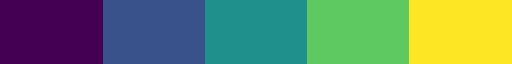

In [180]:
cmap

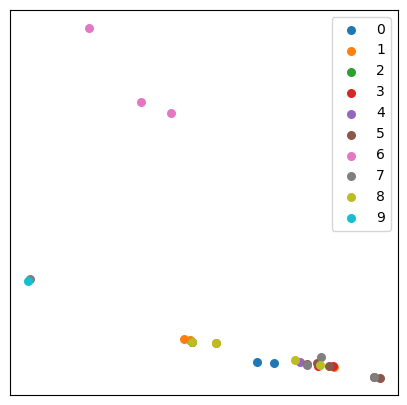

In [185]:
fig, ax = plt.subplots(figsize=(5,5))
scprep.plot.scatter2d(gene_phate, c='lightgray', ax=ax, mask=pd.Series(genes).isin(np.array([y for x in genes_of_interest for y in x])))
for i,geneset in enumerate(genes_of_interest):
    scprep.plot.scatter2d(gene_phate, ax=ax, mask=pd.Series(genes).isin(geneset), ticks=None, s=30, label=i)
plt.legend()

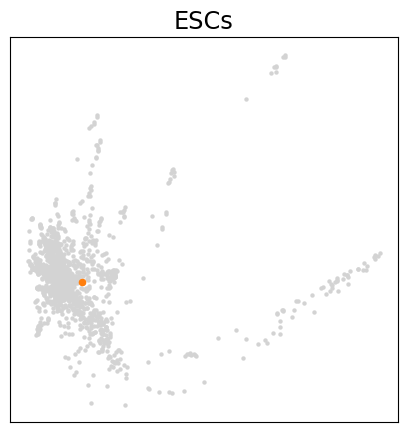

In [50]:
fig, ax = plt.subplots(figsize=(5,5))
scprep.plot.scatter2d(gene_phate, c='lightgray', ax=ax)
for i,gene in enumerate(['NANOG', 'POU5F1']):
    scprep.plot.scatter2d(gene_phate, ax=ax, mask=genes == gene, ticks=None, s=20, title='ESCs')

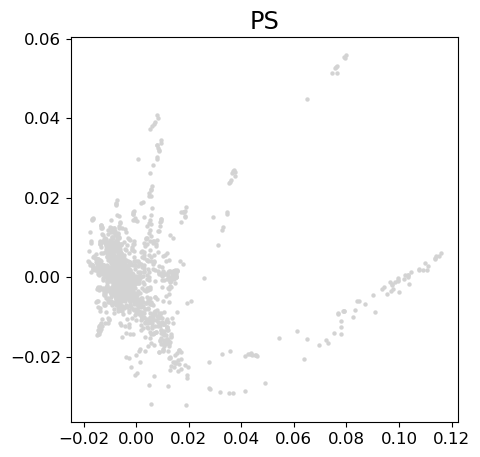

In [51]:
fig, ax = plt.subplots(figsize=(5,5))
scprep.plot.scatter2d(gene_phate, c='lightgray', ax=ax)
for i,gene in enumerate(['EOMES', 'MIXL1', 'CER1', 'SATB1', 'T']):
    scprep.plot.scatter2d(gene_phate, ax=ax, mask=genes == gene, ticks=True, s=20, title='PS')

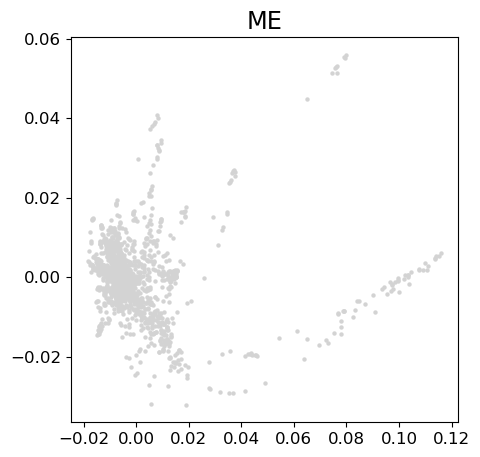

In [53]:
fig, ax = plt.subplots(figsize=(5,5))
scprep.plot.scatter2d(gene_phate, c='lightgray', ax=ax)
for i,gene in enumerate(['T']):
    scprep.plot.scatter2d(gene_phate, ax=ax, mask=genes == gene, ticks=True, s=20, title='ME')

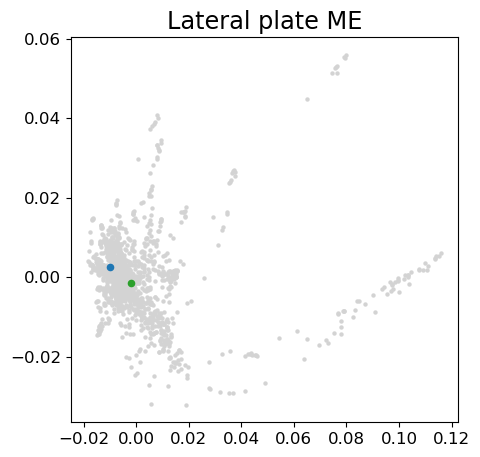

In [54]:
fig, ax = plt.subplots(figsize=(5,5))
scprep.plot.scatter2d(gene_phate, c='lightgray', ax=ax)
for i,gene in enumerate(['TBX5', 'HOXD9', 'MYC']):
    scprep.plot.scatter2d(gene_phate, ax=ax, mask=genes == gene, ticks=True, s=20, title='Lateral plate ME')

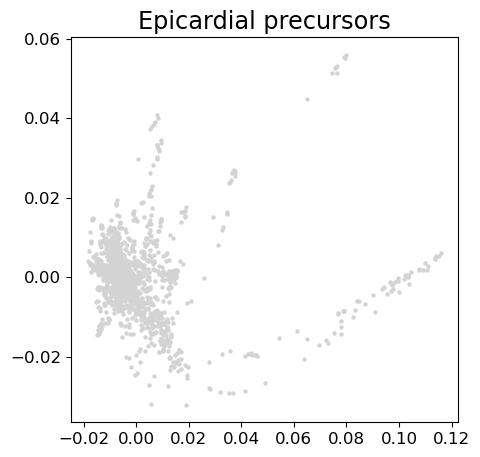

In [55]:
fig, ax = plt.subplots(figsize=(5,5))
scprep.plot.scatter2d(gene_phate, c='lightgray', ax=ax)
for i,gene in enumerate(['WT1']):
    scprep.plot.scatter2d(gene_phate, ax=ax, mask=genes == gene, ticks=True, s=20, title='Epicardial precursors')

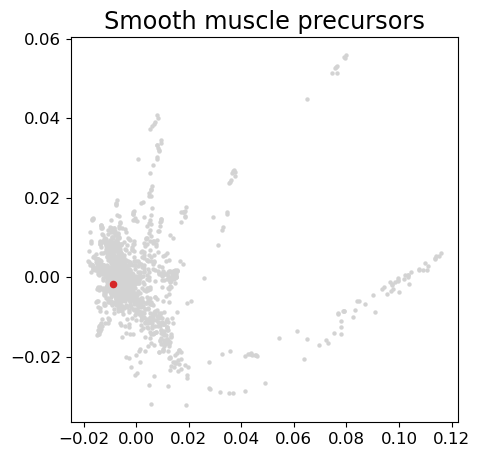

In [56]:
fig, ax = plt.subplots(figsize=(5,5))
scprep.plot.scatter2d(gene_phate, c='lightgray', ax=ax)
for i,gene in enumerate(['TBX18', 'SIX2', 'TBX15', 'PDGFRA']):
    scprep.plot.scatter2d(gene_phate, ax=ax, mask=genes == gene, ticks=True, s=20, title='Smooth muscle precursors')

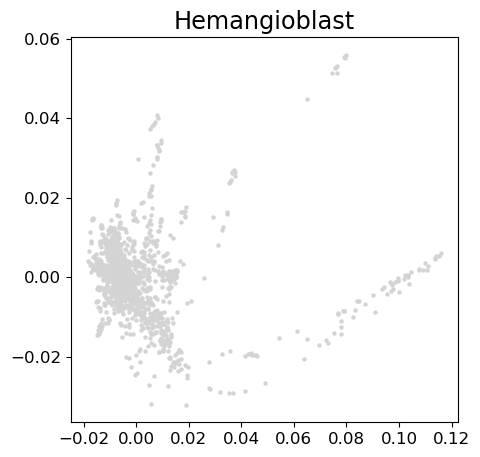

In [57]:
fig, ax = plt.subplots(figsize=(5,5))
scprep.plot.scatter2d(gene_phate, c='lightgray', ax=ax)
for i,gene in enumerate(['TAL1', 'CD34', 'PECAM1']):
    scprep.plot.scatter2d(gene_phate, ax=ax, mask=genes == gene, ticks=True, s=20, title='Hemangioblast')

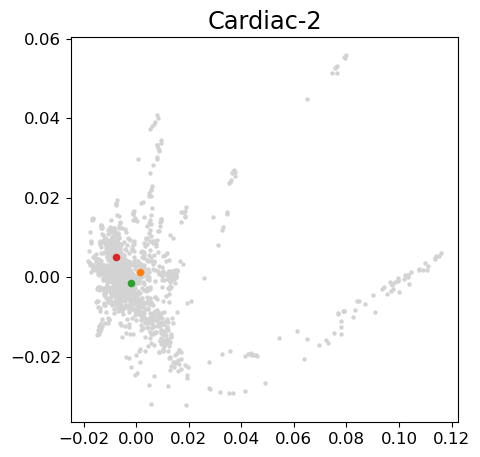

In [58]:
fig, ax = plt.subplots(figsize=(5,5))
scprep.plot.scatter2d(gene_phate, c='lightgray', ax=ax)
for i,gene in enumerate(['NKX2-5', 'LEF1', 'MYC', 'GATA5']):
    scprep.plot.scatter2d(gene_phate, ax=ax, mask=genes == gene, ticks=True, s=20, title='Cardiac-2')

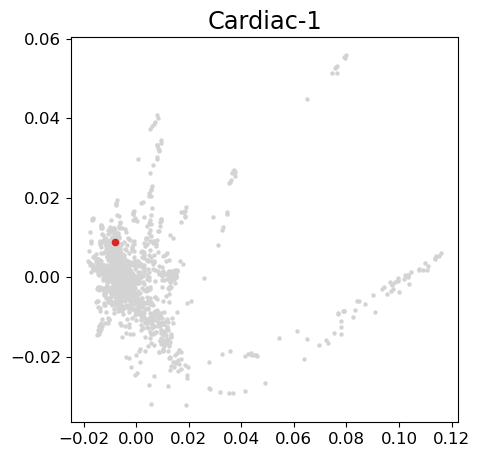

In [59]:
fig, ax = plt.subplots(figsize=(5,5))
scprep.plot.scatter2d(gene_phate, c='lightgray', ax=ax)
for i,gene in enumerate(['T', 'CER1', 'GATA4', 'GATA6']):
    scprep.plot.scatter2d(gene_phate, ax=ax, mask=genes == gene, ticks=True, s=20, title='Cardiac-1')

In [34]:
fig, ax = plt.subplots(figsize=(5,5))
scprep.plot.scatter2d(gene_phate, c='lightgray', ax=ax)
for i,gene in enumerate(['TNNT2']):
    scprep.plot.scatter2d(gene_phate, ax=ax, mask=genes == gene, ticks=True, s=20, title='Cardiac precursors')

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (3333670427.py, line 3)

In [28]:
genes[gene_phate[:, 0] < -0.05]

array(['BARX2', 'FGB', 'FGG', 'GPRC5A', 'SERPINB2', 'SPINK1'],
      dtype='<U19')

In [25]:
neuronal_lineage = ['NANOG', 'POU5F1', 'OTX2', 'GBX2', 'OLIG3', 'HOXD1', 'ZIC2', 'ZIC5', 'HOXA2', 'HOXB1', 'GLI3', 'LHX2', 'LHX5', 'PAX6', 'SIX3', 'SIX6', 'PAX3', 'FOXD3', 'SOX9', 'SOX10', 'NES', 'MAP2']
neuronal_subtypes = [['KLF7', 'ISL1', 'DLX1', 'ONECUT1', 'ONECUT2'], ['OLIG1', 'NPAS1', 'LHX2', 'NR2F1', 'OLIG1', 'NPAS1', 'DMRT3', 'LMX1A'], ['NKX2-8', 'EN2', 'SOX1'], ['PAX6', 'ZBTB16']]
all_neuronal = neuronal_lineage + [y for x in neuronal_subtypes for y in x]

In [26]:
cardiac_lineage = ['NANOG', 'POU5F1', 'EOMES', 'MIXL1', 'CER1', 'SATB1', 'T', 'NKX2-5', 'LEF1', 'MYC', 'CER1', 'GATA4', 'GATA5', 'GATA6', 'TNNT2']

In [27]:
cmap = plt.get_cmap('viridis', len(neuronal_lineage))

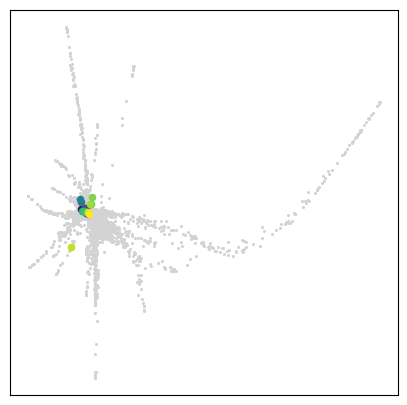

In [29]:
fig, ax = plt.subplots(figsize=(5,5))
scprep.plot.scatter2d(gene_phate, c='lightgray', ax=ax)
for i,gene in enumerate(neuronal_lineage):
    scprep.plot.scatter2d(gene_phate, color=cmap(i), ax=ax, mask=genes == gene, ticks=None, s=20)
#for set in neuronal_subtypes:
#    scprep.plot.scatter2d(gene_phate, color=cmap(i), ax=ax, mask=pd.Series(genes).isin(set), ticks=None, s=20)


In [71]:
signal_embedding = pd.DataFrame(results['signal_embedding'], index=genes)

In [77]:
neuronal_gene_phate_op = phate.PHATE(random_state=42)
neuronal_gene_phate = neuronal_gene_phate_op.fit_transform(signal_embedding.loc[all_neuronal].values)

Calculating PHATE...
  Running PHATE on 40 observations and 128 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 15
  Calculating diffusion potential...
  Calculating metric MDS...
Calculated PHATE in 0.02 seconds.


/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/graphtools/graphs.py:283: RuntimeWarning: Detected zero distance between samples 11 and 29, 13 and 38, 27 and 31, 28 and 32. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


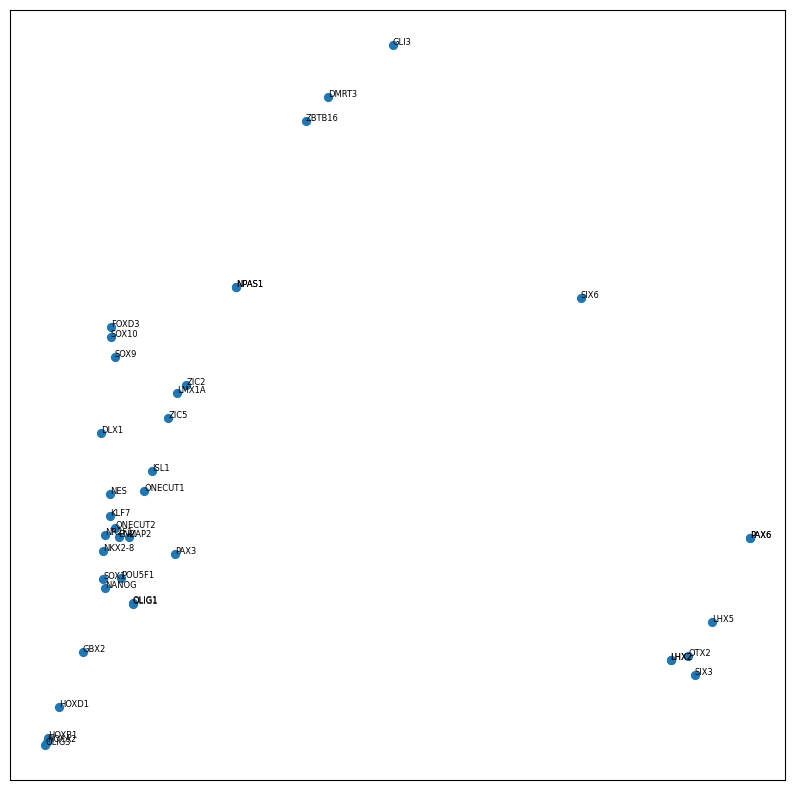

In [88]:
fig, ax = plt.subplots(figsize=(10,10))
scprep.plot.scatter2d(neuronal_gene_phate, ax=ax, ticks=None)
for i,gene in enumerate(all_neuronal):
    ax.annotate(gene, (neuronal_gene_phate[i, 0], neuronal_gene_phate[i, 1]), fontsize=6)
fig.savefig('results/eb_results/neuronal_embedding.png', dpi=500)